# Exploring representation bias of countries in Wikipedia using the Wikispeedia Dataset

## Project Milestone 3

### Research Question: 
* Is there a representation bias in Wikipedia about countries?
* What does the behaviour of the players tell us about their cultural knowledge about countries?

### Notebook structure

- Loading data
- Data wrangling
- Data analysis
    - Part 1: Descriptive statistics and naive statistical analysis of the Wikispeedia Dataset
        * A: Exploratory data analysis
        * B: Length of the articles* and their number of hyperlinks
        * C: Sentiment analysis of articles*
    - Part 2: Descriptive statistics and naive statistical analysis about the behaviour of the players
        * A: How different is the ratio of finished pathways, where articles* are the start/target?
        * B: How different is the length of the pathway taken respectively the time needed, where articles* are the start/target?
        * C: How often does an article* appear in a pathway where it is neither the start nor the traget?
    - Part 3: Analysis of biases
        * A: Establish baseline (e.g. expected length for world mean population or economic strength)
        * B: By investigating article length, article sentiment or number of hyperlinks while controlling for e.g. population size, economic power or if English is an official language, is there a representation bias based on countries in Wikipedia?  
        * C: While controlling for as much of the bias in the dataset as we can, do we see additional bias of the players in the pathways they have taken? -> culutral bias (how much do players know about countries, since we can not conclude anything without demographic informations about the players)

    *articles = Wikipedia article of a country
    
    To compare all countries (more than 200) would be too confusing, therefore they are grouped by region, economic developement and population to plot the graphs.

In [31]:
# Loading all the necessary packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from urllib.parse import unquote
import seaborn as sns
import networkx as nx
#import plotly.express as px
#import plotly.graph_objects as go
import statsmodels.formula.api as smf
import scipy.stats as stats
from urllib.parse import unquote
import plotly.express as px

# import helper functions from python script
import helper as hlp
import sentiment_analysis as sa

## Loading & cleaning data

In [3]:
articles_load =  pd.read_csv("data/wikispeedia_paths-and-graph/articles.tsv", sep='\t', names=["article"], skiprows=12)
links_load = pd.read_csv("data/wikispeedia_paths-and-graph/links.tsv", sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished_load = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished_load = pd.read_csv("data/wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_load = np.loadtxt("data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt", dtype=str, comments="#", unpack=False)
categories_load = pd.read_csv("data/wikispeedia_paths-and-graph/categories.tsv", sep='\t', names=["article", "category"], skiprows = 13)
sentiment_analysis_of_countries_load =  pd.read_csv("data/sentiment_analysis.csv")

# seperate each row and create a matrix with all the shortest distance
table_distance = np.array([[int(c) if c != '_' else -1 for c in row] for row in shortest_distance_load])

# load, keep only necessery columns and rename them
UN_countries_load = pd.read_csv("data/UNSD — Methodology.csv", delimiter = ';')
UN_countries_load = UN_countries_load[['Region Name', 'Sub-region Name','Intermediate Region Name', 'Country or Area',
                                       'Least Developed Countries (LDC)', 'Land Locked Developing Countries (LLDC)', 'Small Island Developing States (SIDS)']]
UN_countries_load.columns = ['Region Name', 'Sub-region Name','Intermediate Region Name', 'Country',
                                       'LDC', 'LLDC', 'SIDS']

UN_countries_by_economies_load = pd.read_csv("data/countries_by_income_category.csv")
UN_countries_by_economies_load.columns = ['Country', 'Economic classification']

UN_countries_by_population_load = pd.read_csv("data/UNdata_population_size.csv")

# Translating all article titles to user readable format
articles_load['article'] = articles_load['article'].apply(unquote)
links_load['link_source'] = links_load['link_source'].apply(unquote)
links_load['link_target'] = links_load['link_target'].apply(unquote)
paths_finished_load['path'] = paths_finished_load['path'].apply(unquote)
paths_unfinished_load['path'] = paths_unfinished_load['path'].apply(unquote)
paths_unfinished_load['target'] = paths_unfinished_load['target'].apply(unquote)
categories_load['article'] = categories_load['article'].apply(unquote)

## Data wrangling 
The imported is transformed and merged into several pd.DataFrames, that are needed for the Data Analysis

1. path_overview: combiens information about all the path of all games played (unfinished and finished)
2. main_categories: dataframe that contains the main category of all Wikipedia articles
3. df_country_regions: dataframe that contains the region a country belongs to
4. UN_countries_by_economies: contains economic classifications per country
5. plaintext_articles: contains the whole content of Wikipedia articles about countries
6. sentiment_analysis_of_countries: contains results from sentiment analysis of countries Wikipedia article
7. UN_countries_by_population: contains the population of each country in 2014
8. country_links_df: contains for each Wikipedia article the number of hyperlink in and out
9. country_path_overview: contains all games played (= pathways), where the target was a country. The dataframe is also populated with the Region and the Economic classification of the target country.



### 1. Create path_overview_df DataFrame


In [4]:
# expand the finished paths
paths_finished = paths_finished_load.copy()
path_fin = paths_finished.copy()
path_fin = path_fin.assign(source=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                           target=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                           game_path=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                           completed=True)

# expand the unfinished paths
paths_unfinished = paths_unfinished_load.copy()
path_ufin = paths_unfinished.copy()
path_ufin = path_ufin.assign(source=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                             failure_article=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                             game_path=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                             completed=False,
                             target=paths_unfinished["target"])

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin], ignore_index=True)[["source", "target",  "hashedIpAddress", "timestamp",
                                                                     "durationInSec", "game_path",
                                                                     "completed", "rating","type"]]

articles = articles_load.copy()
articles["index"] = articles.index
help_articles = articles.set_index("article")

# shortest path length is added to the path_overview
# Create a copy of the 'path_overview' DataFrame to avoid modifying the original
path_overview_copy = path_overview.copy()

# Apply the find_path_distance function to each row
path_overview_copy['shortest_distance'] = path_overview_copy.apply(
    lambda row: hlp.find_path_distance(row['source'], row['target'], help_articles, table_distance), axis=1
)

# Update the original 'path_overview' DataFrame with the new 'shortest_distance' column
path_overview['shortest_distance'] = path_overview_copy['shortest_distance']

#remove all rows where the source or target article is not among the available articles in the dataset
path_overview = path_overview.drop(path_overview[~(path_overview['source'].isin(articles['article'].array))].index)
path_overview = path_overview.drop(path_overview[~(path_overview['target'].isin(articles['article'].array))].index)

# remove all rows where there is no path between the source article and target article
path_overview = path_overview.drop(path_overview[path_overview['shortest_distance'] == -1].index) 
path_overview.insert(4, 'shortest_distance', path_overview.pop('shortest_distance'))

# Translating article names from URL to latin characters
path_overview['source'].apply(unquote)
path_overview['target'].apply(unquote)

# Rename and reste index
path_overview_df = path_overview.copy()

# Changes names to be consitent from United_States to United States
path_overview_df['source'] = [el.replace('_',' ') for el in path_overview_df['source']]
path_overview_df['target'] = [el.replace('_',' ') for el in path_overview_df['target']]

display(path_overview_df)

,source,target,hashedIpAddress,timestamp,shortest_distance,durationInSec,game_path,completed,rating,type
0,14th century,African slave trade,6a3701d319fc3754,1297740409,3.0,166,8,True,NaN,NaN
1,14th century,African slave trade,3824310e536af032,1344753412,3.0,88,4,True,3.0,NaN
2,14th century,African slave trade,415612e93584d30e,1349298640,3.0,138,7,True,NaN,NaN
3,14th century,Greece,64dd5cd342e3780c,1265613925,2.0,37,3,True,NaN,NaN
4,14th century,John F. Kennedy,015245d773376aab,1366730828,3.0,175,6,True,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
76188,Franz Kafka,Cholera,109ed71f571d86e9,1389787605,3.0,180,7,False,NaN,restart
76189,Modern history,Hollandic,232f992e57d43e8d,1389787697,3.0,6,0,False,NaN,restart
76190,Computer programming,The Beatles,2e09a7224600a7cd,1389798400,3.0,1900,4,False,NaN,timeout
76191,Jamaica,Alan Turing,60af9e2138051b96,1389799481,3.0,1903,3,False,NaN,timeout


### 2.Create main_categories_df DataFrame

In [5]:
# Apply the custom function hlp.extract_subject_category() to create a new 'subject_category' column
categories = categories_load.copy()
categories['subject_category'] = categories['category'].apply(hlp.extract_subject_category)

# Create a dataFrame with only the relevant columns and remove _
categories['article'] = [el.replace('_',' ') for el in categories['article']]
main_categories_df = categories[['article', 'subject_category']]

# Display the new DataFrame
main_categories_df.head()

,article,subject_category
0,Áedán mac Gabráin,History
1,Áedán mac Gabráin,People
2,Åland,Countries
3,Åland,Geography
4,Édouard Manet,People


### 3. Create country_regions_df dataframe

In [6]:
# Below we find the articles which have different names to those outlined in the UN dataset. We then manually found the corresponding name in the UN
# dataset and created a dictionary to map article names -> UN dataset name
UN_countries = UN_countries_load.copy()

countries = main_categories_df[main_categories_df['subject_category'] == 'Countries']['article'].values
countries = [cntry.replace('_',' ') for cntry in countries]

# United Arab Emirates Problem -> Abu Dhabi / Dubai are not countries etc. 
# If confusion, the country with biggest population is kept
countries_to_remove = ['Abu Dhabi', 'Dubai', 'Easter Island', 'Galápagos Islands', 'Korea', 'Abkhazia', 'Republic of China']
countries = [cntry for cntry in countries if cntry not in countries_to_remove]

countries_missing = []

for country in countries:
    country = country.replace('_',' ')
    if country not in UN_countries['Country'].values:
        countries_missing.append(country)

# "China Problem" we keep Taiwan  -> Taiwan, Republic of China -> deleted (same as Taiwan),
# Tibet -> Tibet, People's Republic of China -> China

replacement_country_names = [
    'Åland Islands', 'Ireland', 'Bolivia (Plurinational State of)',
    'Brunei Darussalam', 'Côte d’Ivoire', 'Cabo Verde', 'Czechia',
    'Timor-Leste', 'Falkland Islands (Malvinas)', 'Micronesia (Federated States of)',
    'State of Palestine', 'Georgia', 'China, Hong Kong Special Administrative Region',
    'Iran (Islamic Republic of)', '', 'Lao People\'s Democratic Republic', 
    'Republic of Moldova', 'Netherlands (Kingdom of the)', 'Sint Maarten (Dutch part)', 
    'Democratic People\'s Republic of Korea', 'State of Palestine', 'China', 'Ireland',
    'North Macedonia', 'Russian Federation', 'Sao Tome and Principe', 'Serbia', 'Republic of Korea',
    "", 'Eswatini', 'Syrian Arab Republic', 'United Republic of Tanzania', 'Bahamas',
    'Gambia', 'Tibet', 'Türkiye', 'Turkish Republic of Northern Cyprus', 'United Kingdom of Great Britain and Northern Ireland',
    'United States of America', 'Holy See', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'State of Palestine'
]

# Dict style is key: value -> Wikipedia name: UN name
replacement_countries = dict(zip(countries_missing, replacement_country_names))

# Creating a dictionary to map each country to its region
country_to_region = {}

for country in countries:
    country_to_region[country] = hlp.get_region(country, UN_countries, replacement_countries)

# Add manually countries that are not present in the UN dataframe
country_to_region['Kosovo'] = 'Eastern Europe'
country_to_region['South Ossetia'] = 'Western Asia'
country_to_region['Tibet'] = "Central Asia"
country_to_region['Turkish Republic of Northern Cyprus'] = "Southern Europe"	


country_region_df = pd.DataFrame.from_dict(country_to_region, 
                                           orient='index',
                                           dtype=None,
                                           columns=['region'])

country_region_df.reset_index(inplace=True)
country_region_df.rename(columns={"index": "article"}, inplace=True)

# Rename Latin America and the Caribbean to Latin America
country_region_df['region'] = country_region_df['region'].replace('Latin America and the Caribbean', 'Latin America')
country_region_df.columns = ['Country', 'Region']
display(country_region_df)

,Country,Region
0,Åland,Northern Europe
1,Éire,Northern Europe
2,Afghanistan,Southern Asia
3,Albania,Southern Europe
4,Algeria,Northern Africa
...,...,...
217,West Bank,Western Asia
218,Western Sahara,Northern Africa
219,Yemen,Western Asia
220,Zambia,Sub-Saharan Africa


### 4. Create UN_countries_by_economies Dataframe

In [7]:
# hard coded changes in country names that can't be read properly from the .csv file
read_csv_names = ['Turkiye', 'China Hong Kong Special Administrative Region', 'Cote d Ivoire']
new_names = ["Türkiye", "China, Hong Kong Special Administrative Region", "Côte d’Ivoire"]
UN_to_modify = UN_countries_by_economies_load.copy()
for i in range(len(read_csv_names)-1):
    country_index = np.where(UN_countries_by_economies_load['Country']==read_csv_names[i])[0][0]
    UN_to_modify.at[country_index, 'Country'] = new_names[i]

UN_countries_by_economies = pd.merge(UN_countries, UN_to_modify, how='left', on='Country')[['Country', 'LDC', 'LLDC', 'SIDS', 'Economic classification']]
# Show countries that are missing an economic classification (should be 248-163=85)
missing_countries = UN_countries_by_economies[UN_countries_by_economies['Economic classification'].isna()]['Country'].values

# Rename Countries to match the names of English Wikipedia
replacement_countries_OLD_NEW = dict([(value, key) for key, value in replacement_countries.items()])
UN_countries_by_economies['Country'] = UN_countries_by_economies['Country'].map(replacement_countries_OLD_NEW).fillna(UN_countries_by_economies['Country'])
UN_countries_by_economies = UN_countries_by_economies.sort_values('Country').reset_index(drop=True)

# Check if everything went fine
display(UN_countries_by_economies)

,Country,LDC,LLDC,SIDS,Economic classification
0,Afghanistan,x,x,NaN,Low-income
1,Albania,NaN,NaN,NaN,Upper middle income
2,Algeria,NaN,NaN,NaN,Upper middle income
3,American Samoa,NaN,NaN,x,NaN
4,Andorra,NaN,NaN,NaN,NaN
...,...,...,...,...,...
244,Western Sahara,NaN,NaN,NaN,NaN
245,Yemen,x,NaN,NaN,Lower middle income
246,Zambia,x,x,NaN,Lower middle income
247,Zimbabwe,NaN,x,NaN,Low-income


### 5. Create plaintext_articles_df Dataframe

In [8]:
# Create np.array with name of all articles that are about a country
countries = main_categories_df[main_categories_df['subject_category'] == 'Countries']['article'].values
# to read names we need United_States
countries = [cntry.replace(' ','_') for cntry in countries]

# Directory where the .txt files are stored
directory = "data/plaintext_articles/" 

# Initialize an empty list to store the data
data = []

# Iterate over all countries
for country in countries:
    file_path = directory + country + '.txt'

# Open the file and read its content into a string
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            load_file_content = file.read()
            file_content = load_file_content[15:].replace("\n\n2007 Schools Wikipedia Selection", "")

    # Add filname, content and article length to the data list
        data.append((country, file_content, len(file_content)))

# Create a DataFrame from the data list
plaintext_articles = pd.DataFrame(data, columns=['Country', 'Article content', 'Article length'])

# Write United_States as United States
plaintext_articles['Country'] = [cntry.replace('_',' ') for cntry in plaintext_articles['Country']]


# Display the DataFrame
display(plaintext_articles)

,Country,Article content,Article length
0,Abkhazia,Abkhazia. Related subjects: Asian Countries;\n...,33592
1,Abu Dhabi,Abu Dhabi. Related subjects: Countries; Middle...,12072
2,Afghanistan,Afghanistan. Related subjects: Asian Countries...,40240
3,Albania,Albania. Related subjects: Countries; European...,24203
4,Algeria,Algeria. Related subjects: African Countries;\...,34081
...,...,...,...
215,West Bank,West Bank. Related subjects: Countries; Middle...,38456
216,Western Sahara,Western Sahara. Related subjects: African Coun...,25959
217,Yemen,Yemen. Related subjects: Countries; Middle Eas...,28075
218,Zambia,Zambia. Related subjects: African Countries;\n...,31103


### 6. Create sentiment_analysis_of_countries Dataframe

In [9]:
sentiment_analysis_of_countries=sentiment_analysis_of_countries_load.copy().drop('Unnamed: 0', axis='columns')

# add sentiment score (1*nbr_pos_batch + 0*nbr_neu_batch - 1*nbr_neg_batch) / total_batches
sentiment_analysis_of_countries['sentiment score'] = sentiment_analysis_of_countries.copy().apply(
    lambda row: (row.POS_sum - row.NEG_sum) / (row.NEG_count + row.NEU_count + row.POS_count), axis=1)

# Write United_States as United States
sentiment_analysis_of_countries['Country'] = [cntry.replace('_',' ') for cntry in sentiment_analysis_of_countries['Country']]

display(sentiment_analysis_of_countries[sentiment_analysis_of_countries['Sentiment'] != 'NEU'])

,Country,Sentiment,NEG_count,NEG_sum,NEU_count,NEU_sum,POS_count,POS_sum,sentiment score


### 7. Create UN_countries_by_population dataframe

In [10]:
# TODO: change names UN -> Wikipedia

UN_countries_by_population = UN_countries_by_population_load.copy()

# Get index of last country to remove commenting lines
zimbabwe_index = UN_countries_by_population[UN_countries_by_population['Country or Area'] == 'Zimbabwe'].index[0]
UN_countries_by_population = UN_countries_by_population.iloc[:(zimbabwe_index+1)]
UN_countries_by_population = UN_countries_by_population.drop_duplicates(subset='Country or Area', keep='first')

# Only keep needed columns and rename them
UN_countries_by_population = UN_countries_by_population[['Country or Area', 'Year','Value']]
UN_countries_by_population.columns = ['Country', 'Year','Value']
display(UN_countries_by_population)

,Country,Year,Value
0,Afghanistan,2014,2.655675e+07
1,Åland Islands,2014,2.879200e+04
2,Albania,2014,2.895947e+06
4,Algeria,2014,3.911428e+07
5,American Samoa,2014,6.181100e+04
...,...,...,...
282,Viet Nam,2014,9.120380e+07
283,Wallis and Futuna Islands,2014,1.225000e+04
284,Yemen,2014,2.595592e+07
285,Zambia,2014,1.502332e+07


### 8. Create country_links_df Dataframe

In [11]:
links_outdegree = links_load.copy()
links_outdegree.columns = ['article','link_out']
out_degrees = links_outdegree.groupby('article').count()
out_degrees.sort_values(by='link_out', ascending=False, inplace=True)

links_indegree = links_load.copy()
links_indegree.columns = ['link_in','article']
in_degrees = links_indegree.groupby('article').count()
in_degrees.sort_values(by='link_in', ascending=False, inplace=True)

link_counts = out_degrees.merge(in_degrees, how='outer', on='article')
link_counts.reset_index(inplace=True)

#country_links_df = link_counts[link_counts.index.isin(countries)]
#country_links_df = country_links.reset_index()

# Write United_States as United States
link_counts['article'] = [cntry.replace('_',' ') for cntry in link_counts['article']]

link_counts = link_counts.merge(country_region_df, left_on='article', right_on='Country', how='left')
country_links_df = (link_counts.dropna(subset=['Country']))[['article', 'link_out', 'link_in', 'Region']]
country_links_df.columns = ['Country', 'link_out', 'link_in', 'Region']

country_links_df.head()

,Country,link_out,link_in,Region
0,United States,294.0,1551.0,Northern America
7,Lebanon,192.0,114.0,Western Asia
9,Armenia,186.0,99.0,Western Asia
10,Georgia (country),180.0,84.0,Western Asia
12,Turkey,172.0,249.0,Western Asia


### 9. Create country_path_overview dataframe

In [12]:
countries = main_categories_df[main_categories_df['subject_category'] == 'Countries']['article'].values
country_path_overview = path_overview_df[path_overview_df['target'].isin(countries)]

country_path_overview = country_path_overview.merge(country_region_df, 
                                                    left_on='target', 
                                                    right_on='Country', 
                                                    how='left').drop(['Country'], axis=1)
country_path_overview = country_path_overview.merge(UN_countries_by_economies[['Country', 'Economic classification']],
                                                    left_on='target',
                                                    right_on= 'Country',
                                                    how= 'left').drop(['Country'], axis=1)

display(country_path_overview)

,source,target,hashedIpAddress,timestamp,shortest_distance,durationInSec,game_path,completed,rating,type,Region,Economic classification
0,14th century,Greece,64dd5cd342e3780c,1265613925,2.0,37,3,True,NaN,NaN,Southern Europe,High-income
1,2005 Atlantic hurricane season,Spain,0d57c8c57d75e2f5,1287268005,1.0,22,3,True,1.0,NaN,Southern Europe,High-income
2,2005 Atlantic hurricane season,Liechtenstein,0ec465e516314a56,1249908585,2.0,391,5,True,2.0,NaN,Western Europe,NaN
3,2005 Atlantic hurricane season,Liechtenstein,1dbbba9e540a9b9b,1346912342,2.0,227,2,True,5.0,NaN,Western Europe,NaN
4,2005 Atlantic hurricane season,Sweden,2134400014dd016d,1366612470,2.0,53,4,True,NaN,NaN,Northern Europe,High-income
...,...,...,...,...,...,...,...,...,...,...,...,...
4740,Proton,Liechtenstein,1c495c3c72396b19,1388389488,3.0,96,2,False,NaN,restart,Western Europe,NaN
4741,Scotland in the High Middle Ages,Jamaica,405a17d643fa8160,1388625809,2.0,1809,0,False,NaN,timeout,Latin America,Upper middle income
4742,Vanadium,Latvia,580bea917fbb4ced,1389370284,2.0,52,0,False,NaN,restart,Northern Europe,High-income
4743,Literacy,Kyrgyzstan,23f7c6281660209f,1389494317,2.0,679,17,False,NaN,restart,Central Asia,Low-income


## Data analysis - Part 1:
Descriptive statistics and and naive analysis about the Wikispeedia DataSet

1. Introductory analysis
2. Length of Wikipedia Articles
3. Hyperlinks of Wikipedia Articles
4. Sentiment Analysis of Wikipedia Articles


### 1. Introductory analysis


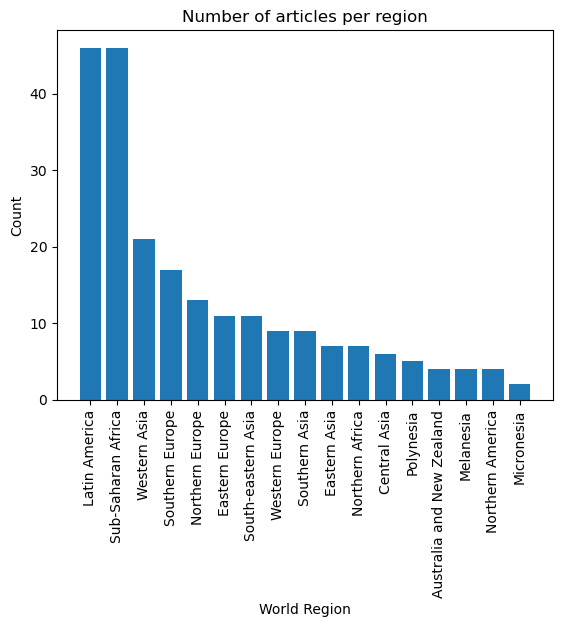

In [13]:
# Plotting the distribution of countries in the dataset based on their region.
countries_per_region = ((country_region_df.groupby('Region').count()).reset_index()).sort_values(by='Country', ascending=False)

plt.bar(countries_per_region['Region'], countries_per_region['Country'])
plt.xticks(rotation=90)
plt.title("Number of articles per region")
plt.xlabel("World Region")
plt.ylabel("Count")
plt.show()

# All countries (and a some more) that are recognized by the UN are included in our Dataset.

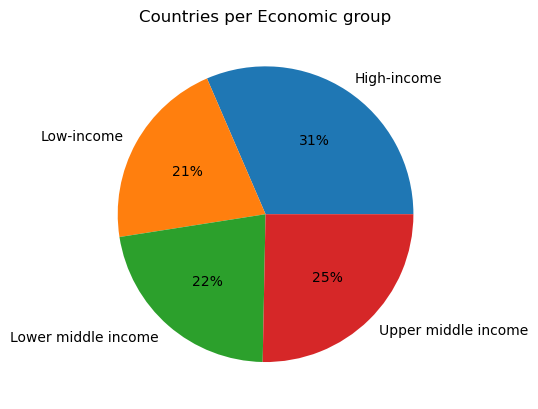

In [14]:
# Plotting the distribution of countries in the dataset based on their economic classification
countries_per_economie = (UN_countries_by_economies.groupby('Economic classification').count()).reset_index()
countries_per_economie.columns = ['Economic_classification', 'Country','Least Developed Countries (LDC)',
                                    'Land Locked Developing Countries (LLDC)','Small Island Developing States (SIDS)']
total_countries = countries_per_economie['Country'].sum()
countries_per_economie['percentage'] = countries_per_economie.apply(lambda row: row.Country / total_countries * 100, axis=1)

plt.pie(countries_per_economie['percentage'], labels=countries_per_economie['Economic_classification'], autopct='%1.f%%')
plt.title("Countries per Economic group")
plt.show()

# The countries are almost evenly distributed among the different income groups

### 2. Length of Wikipedia Articles

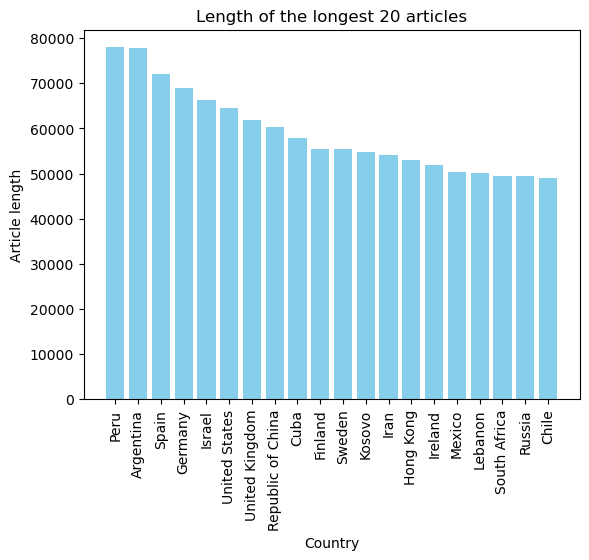

In [15]:
sorted_articles = plaintext_articles.sort_values(by='Article length', ascending=False)

plt.bar(sorted_articles.iloc[:20]['Country'], sorted_articles.iloc[:20]['Article length'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Article length')
plt.title('Length of the longest 20 articles')
# rotate x -> to be able to read
plt.xticks(rotation=90) 
plt.show()

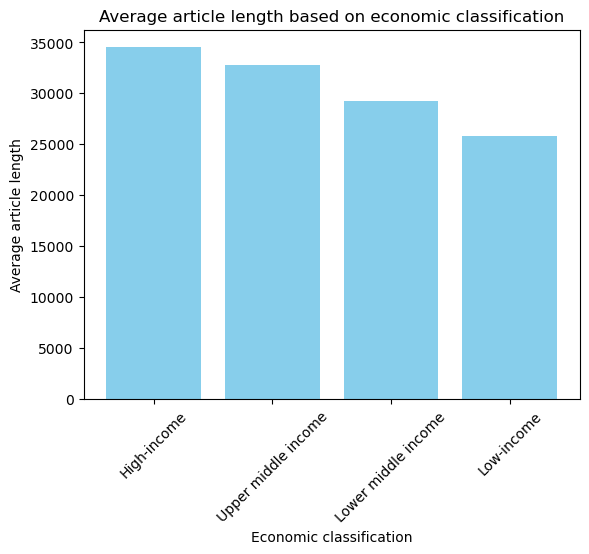

In [16]:
merged_df = pd.merge(plaintext_articles, UN_countries_by_economies, on='Country')
# Group by economic classification and calculate the mean of article length instead of sum
grouped_df = merged_df.groupby('Economic classification')['Article length'].mean().reset_index()
sorted_articles_by_economic_class = grouped_df.sort_values(by='Article length', ascending=False)
plt.bar(sorted_articles_by_economic_class['Economic classification'], sorted_articles_by_economic_class['Article length'], color='skyblue')
plt.xlabel('Economic classification')
plt.ylabel('Average article length')
plt.title('Average article length based on economic classification')
plt.xticks(rotation=45)

plt.show()

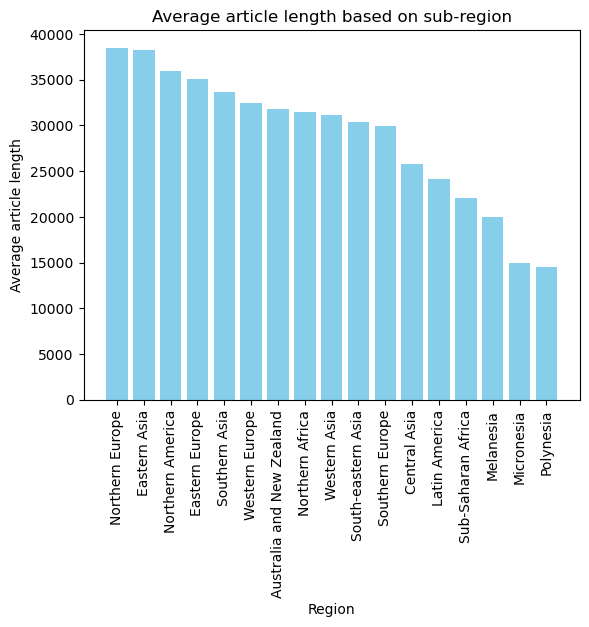

In [17]:
merged_df = pd.merge(country_region_df, plaintext_articles, on='Country')
# Group by economic classification and calculate the mean of article length instead of sum
grouped_df = merged_df.groupby('Region')['Article length'].mean().reset_index()
sorted_articles_by_economic_class = grouped_df.sort_values(by='Article length', ascending=False)
plt.bar(sorted_articles_by_economic_class['Region'], sorted_articles_by_economic_class['Article length'], color='skyblue')
plt.xlabel('Region')
plt.ylabel('Average article length')
plt.title('Average article length based on sub-region')
plt.xticks(rotation=90)

plt.show()

### 3. Number of hyperlinks

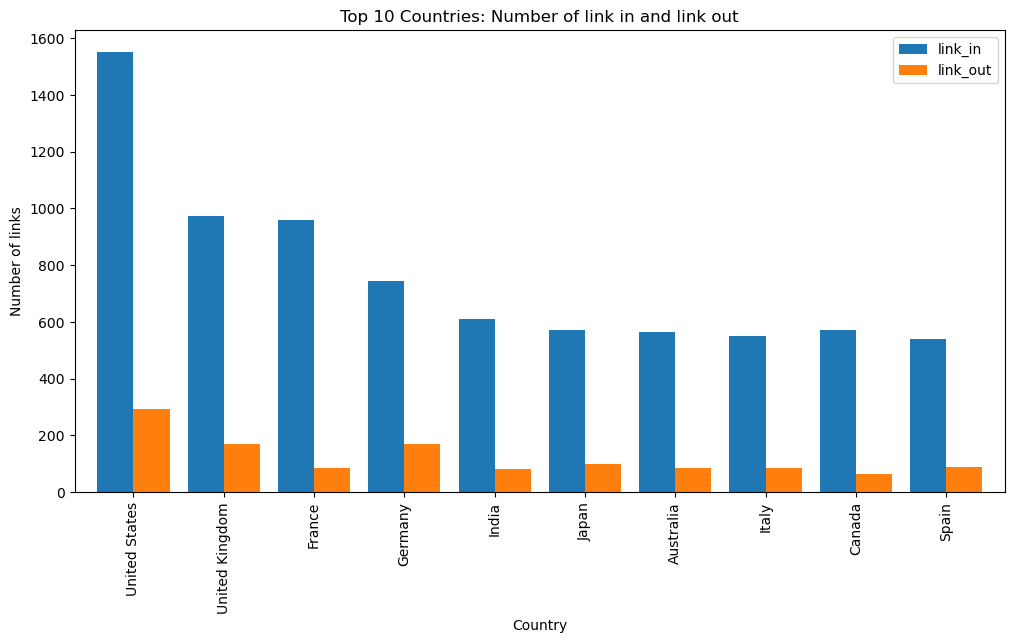

In [18]:
grouped_data = country_links_df.groupby('Country')[['link_in', 'link_out']].sum()
grouped_data['total_links'] = grouped_data['link_in'] + grouped_data['link_out']
grouped_data = grouped_data.sort_values(by='total_links', ascending=False)
top_10_countries = grouped_data.head(10)

fig, ax = plt.subplots(figsize=(12, 6))
top_10_countries[['link_in', 'link_out']].plot(kind='bar', ax=ax, width=0.8)
plt.xlabel('Country')
plt.ylabel('Number of links')
plt.title('Top 10 Countries: Number of link in and link out')
plt.show()

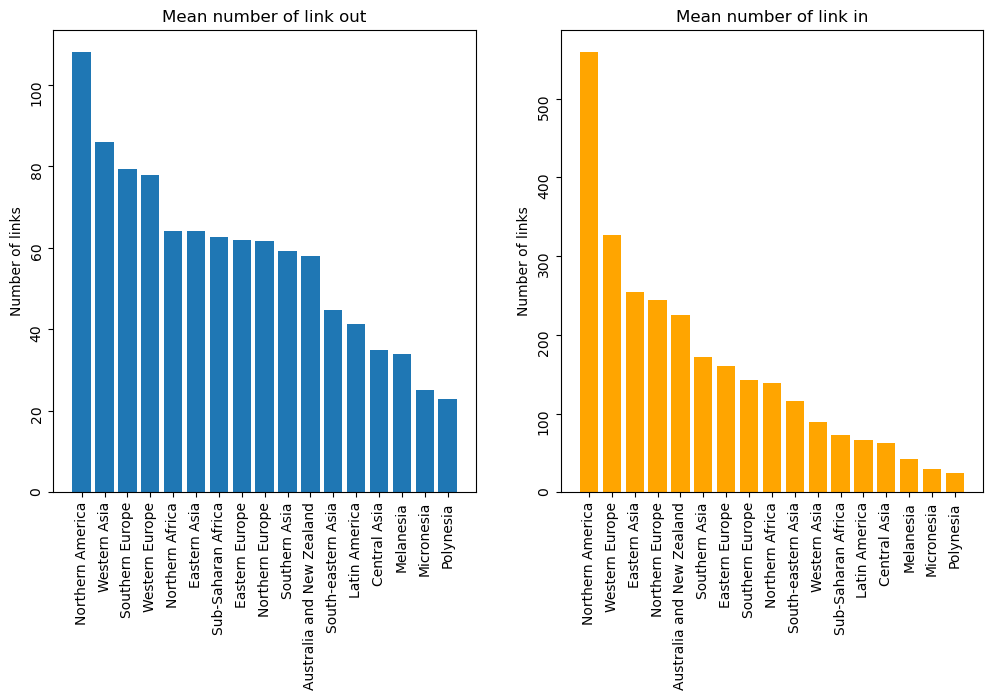

In [19]:
### Summary statistics for the number of in- and out- degrees of each region 

# Initialising empty dataframes
link_out_summary = pd.DataFrame()
link_in_summary = pd.DataFrame()

# Getting summary statistics for each region for in- and out- degrees
links_means = country_links_df[['link_out','link_in','Region']].groupby(['Region']).mean()
links_std = country_links_df[['link_out','link_in','Region']].groupby(['Region']).std()
links_max = country_links_df[['link_out','link_in','Region']].groupby(['Region']).max()
links_median = country_links_df[['link_out','link_in','Region']].groupby(['Region']).median()

for df, kind in [(links_means, 'mean'), (links_median, 'median'), (links_std, "std"), (links_max, 'max')]:
    link_out_summary[kind] = df['link_out']
    link_in_summary[kind] = df['link_in']

# df containing summary statistics
link_out_summary_df = (link_out_summary.reset_index()).sort_values(by='mean', ascending=False)
# df containing summary statistics
link_in_summary_df = (link_in_summary.reset_index()).sort_values(by='mean', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.bar(link_out_summary_df['Region'], link_out_summary_df['mean'])
ax1.set_ylabel('Number of links')
ax1.set_title('Mean number of link out')
ax1.tick_params(labelrotation=90)

ax2.bar(link_in_summary_df['Region'], link_in_summary_df['mean'], color='orange')
ax2.set_ylabel('Number of links')
ax2.set_title('Mean number of link in')
ax2.tick_params(labelrotation=90)
plt.show()

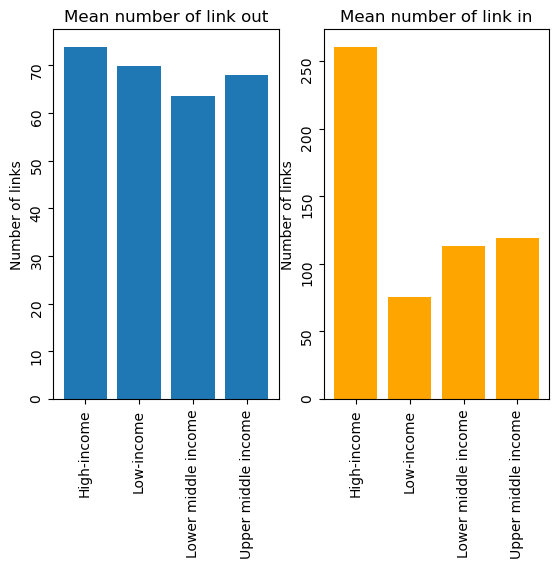

In [20]:
merged_df = country_links_df.merge(UN_countries_by_economies, how='left', on='Country')
merged_df = merged_df[['link_out', 'link_in','Economic classification']]
grouped_df = (merged_df.groupby('Economic classification').mean()).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(grouped_df['Economic classification'], grouped_df['link_out'])
ax1.set_ylabel('Number of links')
ax1.set_title('Mean number of link out')
ax1.tick_params(labelrotation=90)

ax2.bar(grouped_df['Economic classification'], grouped_df['link_in'], color='orange')
ax2.set_ylabel('Number of links')
ax2.set_title('Mean number of link in')
ax2.tick_params(labelrotation=90)
plt.show()

# While the number of links out is similiar (consistence, because also the mean article length is similiar),
# the differences in number of links in (other articles pointing to country articles) is big

### 4. Sentiment Analysis

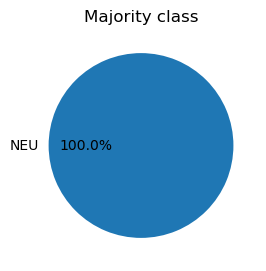

In [21]:
category_counts = sentiment_analysis_of_countries['Sentiment'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Majority class')
plt.show()

# The majority class (= sentiment of the majority of paragraphs in an article) is neutral for all country articles

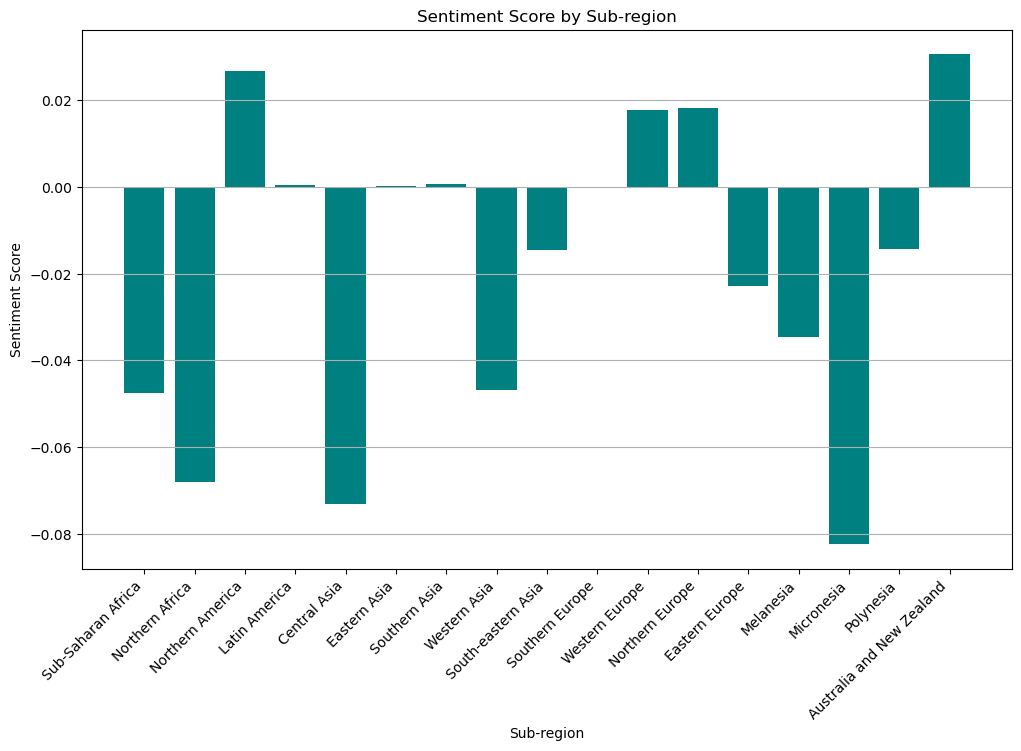

In [22]:
sa_to_plot = (pd.merge(sentiment_analysis_of_countries, country_region_df, how='left', on='Country')[['sentiment score', 'Region']].groupby('Region').mean()).reset_index()

sa_to_plot['Last Word to sort on'] = sa_to_plot['Region'].str.split().str[-1]
sa_to_plot = sa_to_plot.sort_values(by='Last Word to sort on')
sa_to_plot.drop('Last Word to sort on', axis=1, inplace=True)

# Plot
plt.figure(figsize=(12, 7))
plt.bar(sa_to_plot['Region'], sa_to_plot['sentiment score'], color='teal')
plt.title('Sentiment Score by Sub-region')
plt.xlabel('Sub-region')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

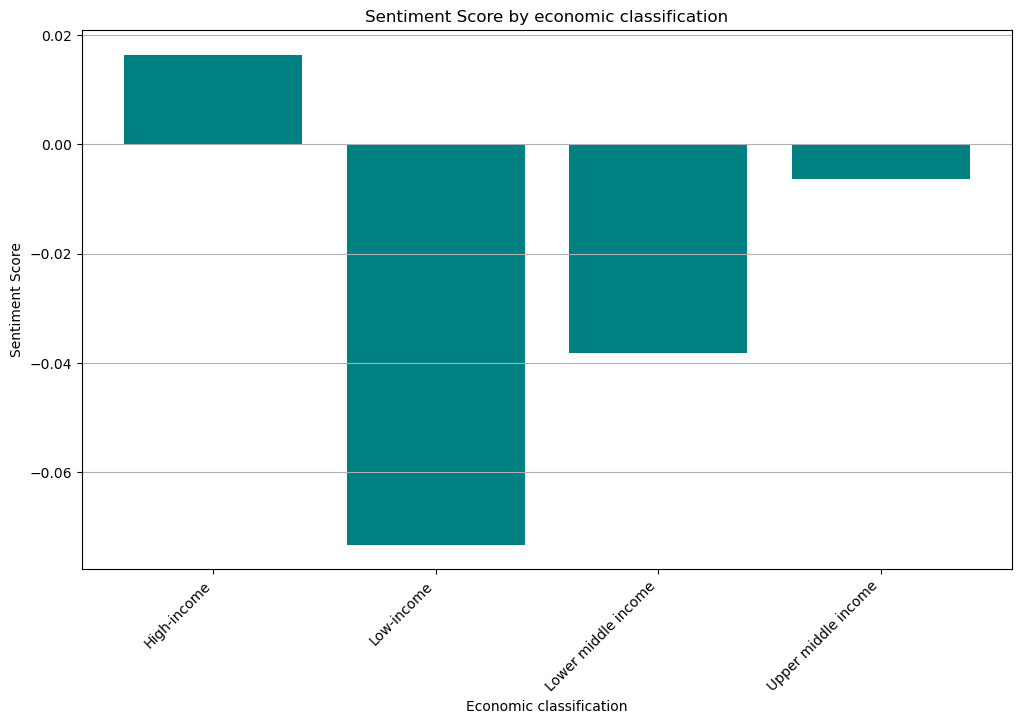

In [23]:
sa_to_plot = (pd.merge(sentiment_analysis_of_countries, UN_countries_by_economies, how='left', left_on='Country', right_on='Country')[['sentiment score', 'Economic classification']].groupby('Economic classification').mean()).reset_index()

# Plot
plt.figure(figsize=(12, 7))
plt.bar(sa_to_plot['Economic classification'], sa_to_plot['sentiment score'], color='teal')
plt.title('Sentiment Score by economic classification')
plt.xlabel('Economic classification')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

# Data Analysis - Part 2:

Descriptive statistics and naive statistical analysis about the behaviour of the players

1. Ratio of finished pathways, where articles* are the target (includes the creation of two helper dataframes, region_paths_df and econ_paths_df)
2. Length of the pathway taken respectively the time needed, where articles* are the target
3. How often does an article* appear in a pathway where it is neither the start nor the traget?

### 1. Ratio of finished pathways

In [24]:
region_completed_count = country_path_overview[['Region','completed','target']].groupby(['Region','completed']).count()
region_count = country_path_overview[['Region','target']].groupby(['Region']).count()

region_paths_df = pd.DataFrame(columns = ['Region', 'Status', 'Proportion'])
index = 0
for region, completion in region_completed_count.index:
    proportion = region_completed_count.loc[(region, completion)] / region_count.loc[region]
    if completion:
        status = 'finished'
    else:
         status = 'unfinished'
    # print(f"Proportion of {status} paths with {region} as target: {round(proportion.values[0]*100,4)}%")
    new_row = {'Region': region, 'Status': status, 'Proportion': round(proportion.values[0]*100,1)}
    region_paths_df.loc[index] = new_row
    index += 1

region_paths_df

,Region,Status,Proportion
0,Australia and New Zealand,unfinished,19.0
1,Australia and New Zealand,finished,81.0
2,Central Asia,unfinished,18.1
3,Central Asia,finished,81.9
4,Eastern Asia,unfinished,7.8
5,Eastern Asia,finished,92.2
6,Eastern Europe,unfinished,10.7
7,Eastern Europe,finished,89.3
8,Latin America,unfinished,17.5
9,Latin America,finished,82.5


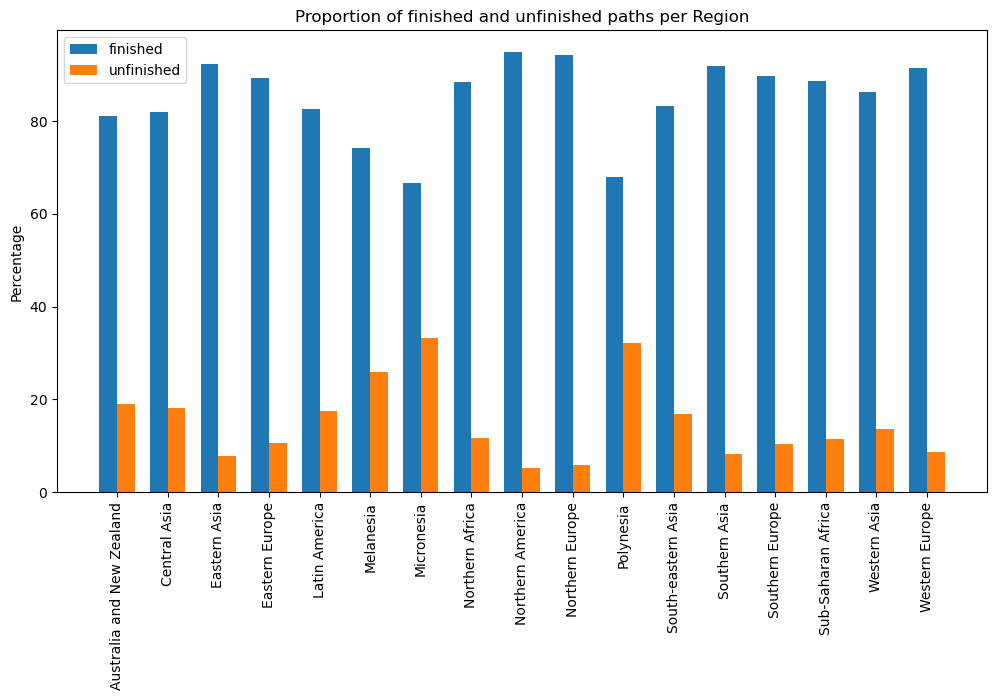

In [33]:
labels = region_paths_df['Region'].unique()
finished_means = region_paths_df[region_paths_df['Status'] == 'finished']['Proportion']
unfinished_means = region_paths_df[region_paths_df['Status'] == 'unfinished']['Proportion']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, finished_means, width, label='finished')
rects2 = ax.bar(x + width/2, unfinished_means, width, label='unfinished')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Proportion of finished and unfinished paths per Region')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()
plt.show()

In [76]:
region_paths_df_updated = pd.DataFrame({
    'Region': labels,
    'Finished Games': finished_means.values,
    'Unfinished Games': unfinished_means.values
})

fig = px.bar(region_paths_df_updated, y='Region', x=['Finished Games', 'Unfinished Games'], orientation='h', barmode='stack',
             labels={'Values1': 'Trace 1', 'Values2': 'Trace 2'},
             title='Stacked Horizontal Bar Chart')

fig.update_layout(
    xaxis=dict(range=[0, 100]),
    height = 600,
    title='Proportion of finished and unfinished games played by Region', 
    xaxis_title='Proportion of finished/unfinished games (%)',
    yaxis_title='Region',
    title_x = 0.5,
    title_y = 0.925,
    legend_title_text = ""
)

fig.show()


In [26]:
econ_completed_count = country_path_overview[['Economic classification','completed','target']].groupby(['Economic classification','completed']).count()
econ_count = country_path_overview[['Economic classification','target']].groupby(['Economic classification']).count()

econ_paths_df = pd.DataFrame(columns = ['Economic classification', 'Status', 'Proportion'])
index = 0
for econ, completion in econ_completed_count.index:
    proportion = econ_completed_count.loc[(econ, completion)] / econ_count.loc[econ]
    if completion:
        status = 'finished'
    else:
         status = 'unfinished'
    # print(f"Proportion of {status} paths with {region} as target: {round(proportion.values[0]*100,4)}%")
    new_row = {'Economic classification': econ, 'Status': status, 'Proportion': round(proportion.values[0]*100,1)}
    econ_paths_df.loc[index] = new_row
    index += 1

econ_paths_df

,Economic classification,Status,Proportion
0,High-income,unfinished,9.3
1,High-income,finished,90.7
2,Low-income,unfinished,10.6
3,Low-income,finished,89.4
4,Lower middle income,unfinished,13.0
5,Lower middle income,finished,87.0
6,Upper middle income,unfinished,11.1
7,Upper middle income,finished,88.9


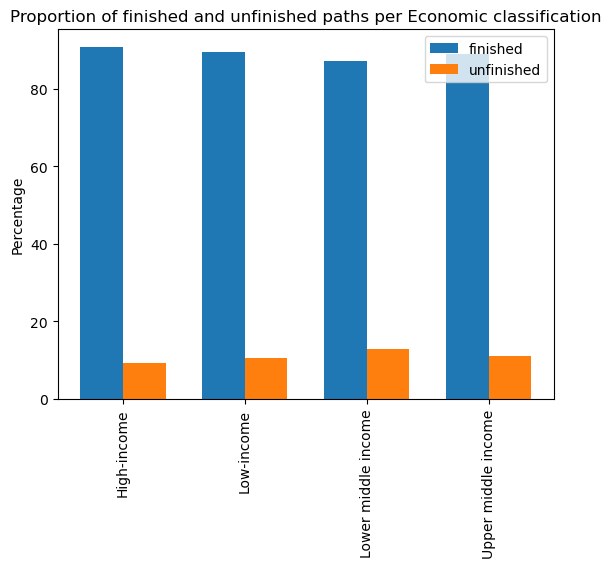

In [27]:
labels = econ_paths_df['Economic classification'].unique()
finished_means = econ_paths_df[econ_paths_df['Status'] == 'finished']['Proportion']
unfinished_means = econ_paths_df[econ_paths_df['Status'] == 'unfinished']['Proportion']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, finished_means, width, label='finished')
rects2 = ax.bar(x + width/2, unfinished_means, width, label='unfinished')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Proportion of finished and unfinished paths per Economic classification')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()
plt.show()

### 2. Length and time needed

In [28]:
# Create helper dataframes of the finished pathways only and group them by Region resp. Economic classification and shortest paths

regions_paths = country_path_overview[['Region','shortest_distance','game_path']][country_path_overview['completed']==True].groupby(by=['Region','shortest_distance']).median().reset_index()
econ_paths = country_path_overview[['Economic classification','shortest_distance','game_path']][country_path_overview['completed']==True].groupby(by=['Economic classification','shortest_distance']).median().reset_index()

regions_paths_1 = regions_paths[regions_paths['shortest_distance'] == 1]
regions_paths_2 = regions_paths[regions_paths['shortest_distance'] == 2]
regions_paths_3 = regions_paths[regions_paths['shortest_distance'] == 3]
regions_paths_4 = regions_paths[regions_paths['shortest_distance'] == 4]

econ_paths_1 = econ_paths[econ_paths['shortest_distance'] == 1]
econ_paths_2 = econ_paths[econ_paths['shortest_distance'] == 2]
econ_paths_3 = econ_paths[econ_paths['shortest_distance'] == 3]
econ_paths_4 = econ_paths[econ_paths['shortest_distance'] == 4]

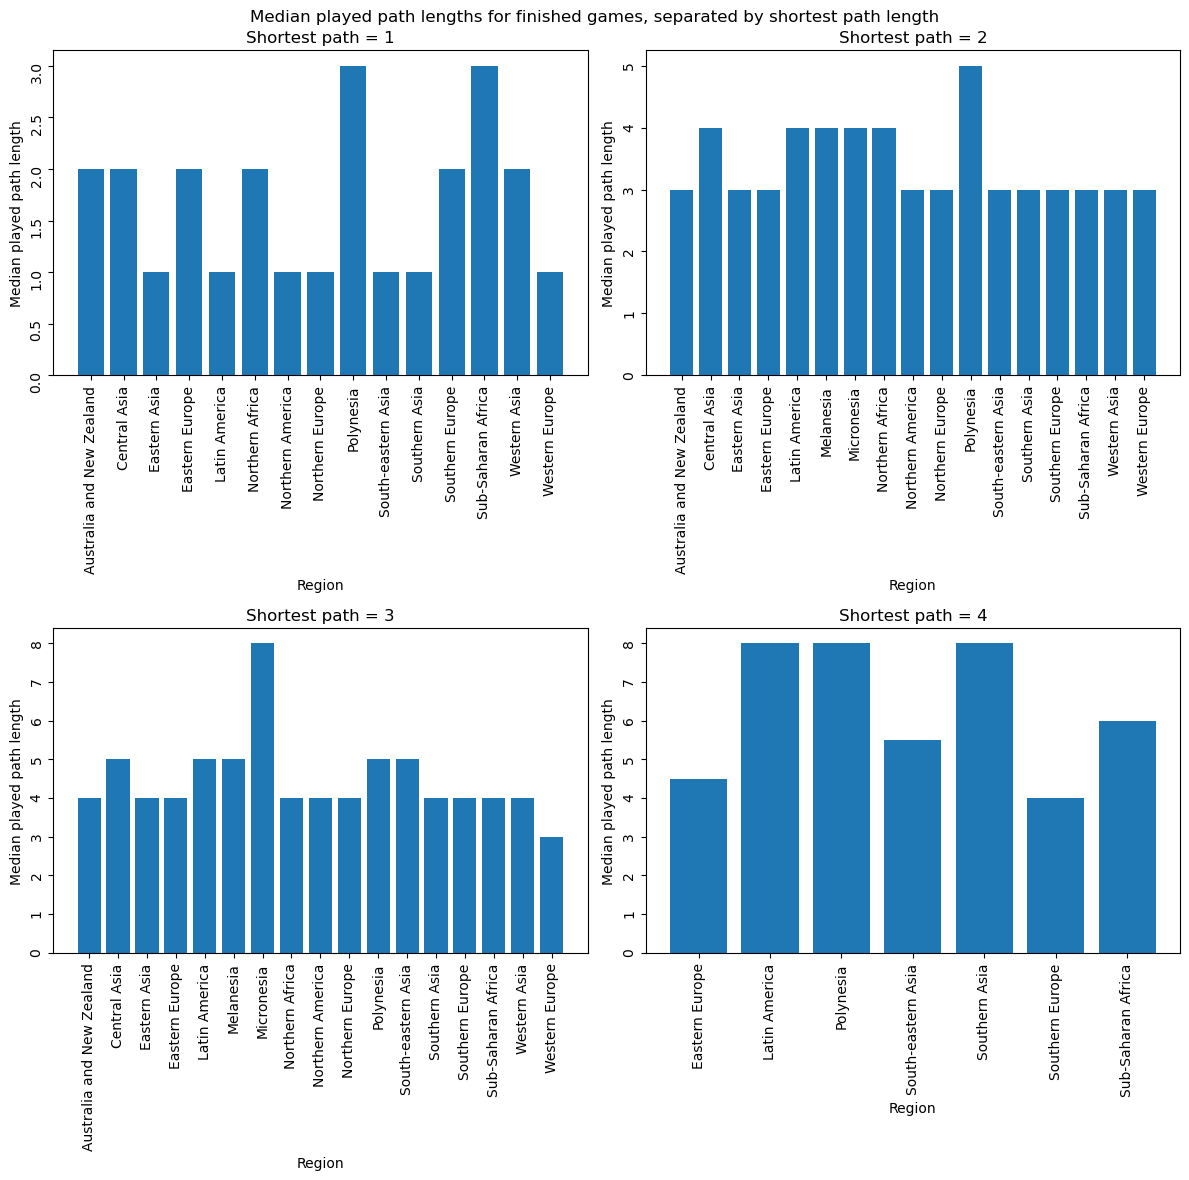

In [29]:
figs, axs = plt.subplots(2,2, figsize=(12,12))

figs.suptitle("Median played path lengths for finished games, separated by shortest path length")

axs[0,0].bar(regions_paths_1['Region'], regions_paths_1['game_path'])
axs[0,0].set_title("Shortest path = 1")
axs[0,0].set_xlabel("Region")
axs[0,0].set_ylabel("Median played path length")
axs[0,0].tick_params(labelrotation=90)

axs[0,1].bar(regions_paths_2['Region'], regions_paths_2['game_path'])
axs[0,1].set_title("Shortest path = 2")
axs[0,1].set_xlabel("Region")
axs[0,1].set_ylabel("Median played path length")
axs[0,1].tick_params(labelrotation=90)

axs[1,0].bar(regions_paths_3['Region'], regions_paths_3['game_path'])
axs[1,0].set_title("Shortest path = 3")
axs[1,0].set_xlabel("Region")
axs[1,0].set_ylabel("Median played path length")
axs[1,0].tick_params(labelrotation=90)

axs[1,1].bar(regions_paths_4['Region'], regions_paths_4['game_path'])
axs[1,1].set_title("Shortest path = 4")
axs[1,1].set_xlabel("Region")
axs[1,1].set_ylabel("Median played path length")
axs[1,1].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

# For shortest path = 4 some regions don't have a value, because all their targets have a shortest length of max. 3

In [85]:
regions_paths_1

,Region,shortest_distance,game_path
0,Australia and New Zealand,1.0,2.0
3,Central Asia,1.0,2.0
6,Eastern Asia,1.0,1.0
9,Eastern Europe,1.0,2.0
13,Latin America,1.0,1.0
21,Northern Africa,1.0,2.0
24,Northern America,1.0,1.0
27,Northern Europe,1.0,1.0
30,Polynesia,1.0,3.0
34,South-eastern Asia,1.0,1.0


In [185]:
import plotly.graph_objects as go

import pandas as pd

# load dataset
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/volcano.csv")

# create figure
fig = go.Figure()

# Add surface trace
fig.add_trace(go.Bar(x=regions_paths_1['Region'], y=regions_paths_1['game_path'], visible=True, name=''))
fig.add_trace(go.Bar(x=regions_paths_2['Region'], y=regions_paths_2['game_path'], visible=False, name=''))
fig.add_trace(go.Bar(x=regions_paths_3['Region'], y=regions_paths_3['game_path'], visible=False, name=''))
fig.add_trace(go.Bar(x=regions_paths_4['Region'], y=regions_paths_4['game_path'], visible=False, name=''))

# Update plot sizing
fig.update_layout(
    width=800,
    height=900,
    autosize=False,
    margin=dict(t=0, b=0, l=0, r=0),
    template="plotly_white",
)

# Update 3D scene options
fig.update_scenes(
    aspectratio=dict(x=1, y=1, z=0.7),
    aspectmode="manual"
)

fig.update_layout(
    height = 700,
    width = 1000,
    margin=dict(b=100, t=150, l=80, r=80),
    title='Finished game lengths for games with shortest path of 1', 
    xaxis_title='Region',
    yaxis_title='Player path length',
    title_x = 0.5,
    title_y = 0.925,
    legend_title_text = "",

    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="1",
                     method="update",
                     args=[{"visible": [True, False, False, False]},
                           {"title": "Finished game lengths for games with shortest path of 1"}]),
                dict(label="2",
                     method="update",
                     args=[{"visible": [False, True, False, False]},
                           {"title": "Finished game lengths for games with shortest path of 2"}]),
                dict(label="3",
                     method="update",
                     args=[{"visible": [False, False, True, False]},
                           {"title": "Finished game lengths for games with shortest path of 3"}]),
                dict(label="4",
                     method="update",
                     args=[{"visible": [False, False, False, True]},
                           {"title": "Finished game lengths for games with shortest path of 4"}]),
            ]),
            showactive=True,
            x=0.16,
            xanchor="left",
            y=1.09,
            yanchor="top"
        )
    ])

# Add annotation
fig.update_layout(
    annotations=[
        dict(text="Shortest Path Length:", showarrow=False,
        x=0, y=1.08, yref="paper", align="left")
    ]
)

fig.show()


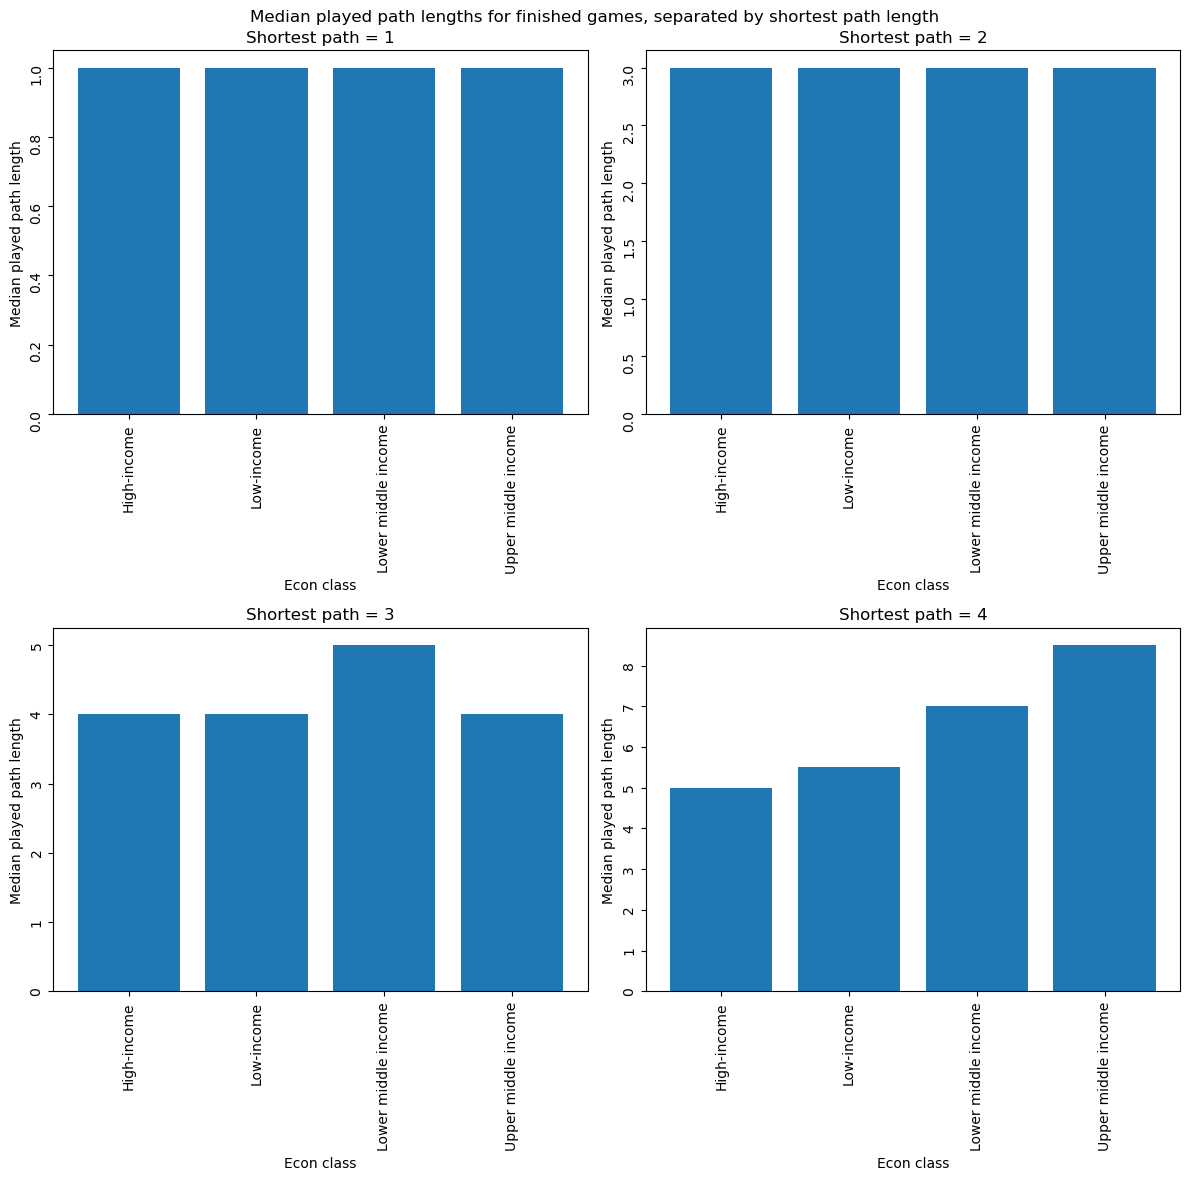

In [186]:
figs, axs = plt.subplots(2,2, figsize=(12,12))

figs.suptitle("Median played path lengths for finished games, separated by shortest path length")

axs[0,0].bar(econ_paths_1['Economic classification'], econ_paths_1['game_path'])
axs[0,0].set_title("Shortest path = 1")
axs[0,0].set_xlabel("Econ class")
axs[0,0].set_ylabel("Median played path length")
axs[0,0].tick_params(labelrotation=90)

axs[0,1].bar(econ_paths_2['Economic classification'], econ_paths_2['game_path'])
axs[0,1].set_title("Shortest path = 2")
axs[0,1].set_xlabel("Econ class")
axs[0,1].set_ylabel("Median played path length")
axs[0,1].tick_params(labelrotation=90)

axs[1,0].bar(econ_paths_3['Economic classification'], econ_paths_3['game_path'])
axs[1,0].set_title("Shortest path = 3")
axs[1,0].set_xlabel("Econ class")
axs[1,0].set_ylabel("Median played path length")
axs[1,0].tick_params(labelrotation=90)

axs[1,1].bar(econ_paths_4['Economic classification'], econ_paths_4['game_path'])
axs[1,1].set_title("Shortest path = 4")
axs[1,1].set_xlabel("Econ class")
axs[1,1].set_ylabel("Median played path length")
axs[1,1].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

### 3. Frequency of article C's involvement in pathways where it was neither the start nor the target (Not finished yet)